In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pmdarima


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 12.0 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split


In [41]:
# Đọc dữ liệu từ file CSV
df = pd.read_csv('/content/drive/MyDrive/StockData/NOK.csv')

# Xử lý dữ liệu
df = df[['Date', 'Close', 'High']]  # Chỉ lấy cột 'Date', 'Close' và 'Volume'
df['Date'] = pd.to_datetime(df['Date'])
df = df.dropna().reset_index(drop=True)

In [56]:
# Chia train, test, validate theo tỉ lệ 7:2:1
train_size = int(0.9 * len(df))
test_size = int(0.1 * len(df))

train_data = df[:train_size]
test_data = df[train_size:]

# Tiến hành huấn luyện mô hình SARIMAX
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])
exog_train = np.array(train_data['High']).reshape(-1, 1)  # Sử dụng cột 'Volume' làm biến exogenous

In [57]:
import pmdarima as pm
import statsmodels.api as sm

#Tìm mô hình SARIMAX tốt nhất
model = auto_arima(y_train, exogenous=exog_train, seasonal=True, m=12, trace=True, error_action='ignore', suppress_warnings=True)
# Fit mô hình SARIMAX (đảm bảo rằng seasonal_order được đặt nếu bạn muốn sử dụng SARIMAX)
model_fit = SARIMAX(y_train, exog=exog_train, order=model.order, seasonal_order=model.seasonal_order).fit()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=-1312.143, Time=2.61 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-1282.980, Time=0.15 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-1311.022, Time=0.38 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-1307.009, Time=0.52 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-1284.799, Time=0.07 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=-1314.143, Time=3.73 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=-1316.132, Time=1.06 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=-1314.143, Time=3.58 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=-1313.586, Time=0.62 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=-1313.147, Time=0.63 sec
 ARIMA(3,1,2)(0,0,0)[12] intercept   : AIC=-1314.152, Time=1.33 sec
 ARIMA(2,1,3)(0,0,0)[12] intercept   : AIC=-1314.146, Time=1.56 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=-1314.088, Time=0.29 sec
 ARIMA(1,1,3)(0,0,0)[12] intercept   : AIC=-1315.663, Time=2.66 sec
 ARIM

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [58]:
x_test = np.array(test_data.index).reshape(-1, 1)

# Dự đoán trên tập kiểm thử (test_data)
y_test = np.array(test_data['Close'])
exog_test = np.array(test_data['High']).reshape(-1, 1)
y_pred_test = model_fit.predict(start=train_size, end=train_size+len(test_data)-1, exog=exog_test)
y_pred_test

array([4.09398898, 4.13036907, 4.15391269, 4.18251488, 4.14698411,
       4.11300643, 4.07286538, 4.033211  , 4.04996024, 4.08947721,
       4.11200946, 4.11198222, 4.11760437, 4.16846685, 4.12888492,
       4.10061492, 4.11191567, 4.11756589, 4.14017518, 4.18539665,
       4.21931277, 4.00450495, 3.95928202, 3.97624028, 3.98754579,
       3.9875457 , 3.99885129, 3.99319842, 4.00450405, 3.99885121,
       3.98754555, 3.99319837, 3.98754554, 3.98754553, 3.98189271,
       3.95928141, 3.98754553, 3.98189271, 3.95928141, 3.97623988,
       4.01015683, 3.95362858, 3.95362858, 3.93101729, 3.90840599,
       3.92536446, 3.91405881, 3.92536446, 3.94232293, 3.91971164,
       3.91971164, 3.90840599, 3.93101729, 3.99319835, 4.01015683,
       4.01580965, 4.0271153 , 4.0271153 , 4.0497266 , 4.06668507,
       4.05537942, 4.06103225, 4.0497266 , 4.0271153 , 4.03276812,
       3.99885118, 3.99885118, 4.02146247, 4.03276812, 3.96493423,
       3.97058706, 3.92536446, 3.90275316, 3.86883622, 3.86883

In [59]:
# Dự đoán giá 30 ngày tiếp theo

next_dates = pd.date_range(start=df['Date'].iloc[-1], periods=30, freq='D')

mean_volume = np.mean(df['High'])
exog_next = np.full((30, 1), mean_volume)
# Tính chỉ số bắt đầu và kết thúc cho dự đoán
start_index = len(df) - len(y_test)
end_index = len(df) - 1

# Tạo mảng exogenous kết hợp cho tập kiểm thử và 30 ngày tiếp theo
exog_combined = np.concatenate((exog_test, exog_next))

# Dự đoán cho tập kiểm thử và 30 ngày tiếp theo
y_pred_combined = model_fit.predict(start=train_size, end=train_size + len(test_data) + 29, exog=exog_combined)

# Tách phần dự đoán cho 30 ngày tiếp theo
y_pred_next_30_days = y_pred_combined[-30:]

# Chuẩn bị DataFrame cho đồ thị
next_30_days = pd.DataFrame({'Date': next_dates, 'Predicted_Close': y_pred_next_30_days})
y_pred_combined



array([4.09398898, 4.13036907, 4.15391269, 4.18251488, 4.14698411,
       4.11300643, 4.07286538, 4.033211  , 4.04996024, 4.08947721,
       4.11200946, 4.11198222, 4.11760437, 4.16846685, 4.12888492,
       4.10061492, 4.11191567, 4.11756589, 4.14017518, 4.18539665,
       4.21931277, 4.00450495, 3.95928202, 3.97624028, 3.98754579,
       3.9875457 , 3.99885129, 3.99319842, 4.00450405, 3.99885121,
       3.98754555, 3.99319837, 3.98754554, 3.98754553, 3.98189271,
       3.95928141, 3.98754553, 3.98189271, 3.95928141, 3.97623988,
       4.01015683, 3.95362858, 3.95362858, 3.93101729, 3.90840599,
       3.92536446, 3.91405881, 3.92536446, 3.94232293, 3.91971164,
       3.91971164, 3.90840599, 3.93101729, 3.99319835, 4.01015683,
       4.01580965, 4.0271153 , 4.0271153 , 4.0497266 , 4.06668507,
       4.05537942, 4.06103225, 4.0497266 , 4.0271153 , 4.03276812,
       3.99885118, 3.99885118, 4.02146247, 4.03276812, 3.96493423,
       3.97058706, 3.92536446, 3.90275316, 3.86883622, 3.86883

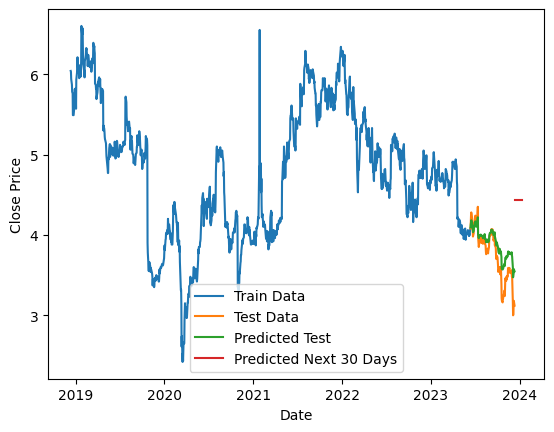

In [60]:
# Vẽ đồ thị
#plt.figure(figsize=(15, 8))
plt.plot(train_data['Date'], train_data['Close'], label='Train Data')
plt.plot(test_data['Date'], test_data['Close'], label='Test Data')
plt.plot(test_data['Date'], y_pred_test, label='Predicted Test')
plt.plot(next_30_days['Date'], next_30_days['Predicted_Close'], label='Predicted Next 30 Days')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [61]:
# Tính MAE
test_mae = mean_absolute_error(y_test, y_pred_test)

# Tính toán RMSE
test_rmse = np.sqrt(np.mean((y_pred_test - y_test)**2))

# Tính MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

test_mape = mean_absolute_percentage_error(y_test, y_pred_test)

# Làm tròn đến số thứ 3 sau dấu phẩy
test_mae = round(test_mae, 3)
test_rmse = round(test_rmse, 3)
test_mape = round(test_mape, 3)

print('Testing MAE:', test_mae)
print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)

Testing MAE: 0.154
Testing RMSE: 0.199
Testing MAPE: 4.419


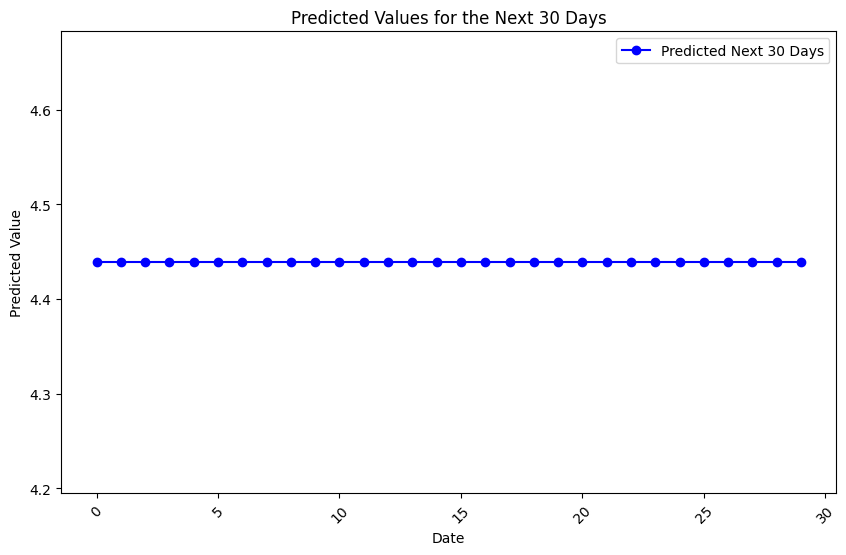

In [62]:
# Vẽ biểu đồ
plt.figure(figsize=(10, 6)) # Set the figure size
plt.plot(y_pred_next_30_days, marker='o', color='b', label='Predicted Next 30 Days')

# Đặt tiêu đề và nhãn
plt.title('Predicted Values for the Next 30 Days')
plt.xlabel('Date')
plt.ylabel('Predicted Value')
plt.xticks(rotation=45) # Rotate x-axis labels for better readability
plt.legend()

# Hiển thị biểu đồ
plt.show()


